In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from src.train import train, test
from src.models import Simple3BlockCNN, SimpleResNetCNN, BNDropout3BlockCNN, AIDetectorResNet
from src.utils import split_data, print_history

Using device: mps


# Poster Detection

In [2]:
BATCH_SIZE = 32
TRAIN_SIZE = 0.8
EPOCHS = 50
LEARNING_RATE = 1e-3
PATIENCE = 10

train_loader, val_loader, test_loader = split_data(root_dir="data/poster-detect", batch_size=BATCH_SIZE)

           Train    Val    Test    Total
-------  -------  -----  ------  -------
Samples     8000   1000    1000    10000
Batches      250     32      32      314


## Training

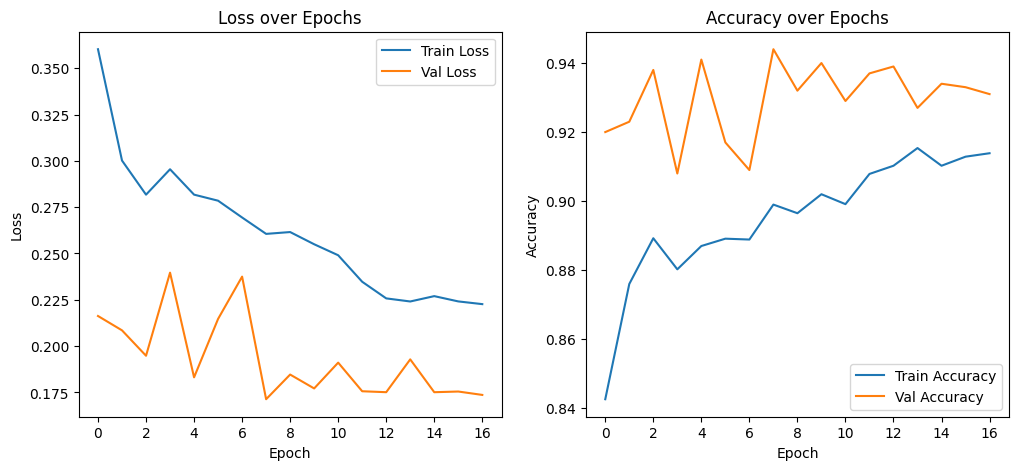

Epoch 17/50
  Train Loss: 0.2227, Train Acc: 0.9139
  Val   Loss: 0.1737, Val   Acc: 0.9310
  Best Val Acc: 0.9440 at Epoch 8
  Learning Rate: 0.000001


Early stopping at epoch 18
History saved to models/SimpleResNetCNN/run_6/history.json


In [3]:
# model = Simple3BlockCNN()
model = SimpleResNetCNN(freeze_backbone=True)
# model = BNDropout3BlockCNN()

criterion = nn.BCEWithLogitsLoss()

# Only optimize the new classifier head (if model is frozen)
optimizer = optim.Adam(model.backbone.fc.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

history = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    patience=PATIENCE
)

In [4]:
history_path = "models/SimpleResNetCNN/run_6/history.json"
print_history(history_path)

Epoch      Train Loss    Val Loss    Train Acc    Val Acc
-------  ------------  ----------  -----------  ---------
1              0.3603      0.2163       0.8426      0.92
2              0.3002      0.2085       0.876       0.923
3              0.2818      0.1948       0.8892      0.938
4              0.2955      0.2397       0.8802      0.908
5              0.2818      0.1831       0.887       0.941
6              0.2785      0.2147       0.8891      0.917
7              0.2694      0.2375       0.8889      0.909
8*             0.2606      0.1713       0.899       0.944
9              0.2616      0.1846       0.8965      0.932
10             0.255       0.1771       0.902       0.94
11             0.2491      0.1911       0.8991      0.929
12             0.2347      0.1756       0.9079      0.937
13             0.2258      0.1751       0.9103      0.939
14             0.2241      0.1928       0.9154      0.927
15             0.227       0.1751       0.9103      0.934
16             0

## Testing

In [5]:
simple_model = Simple3BlockCNN()
simple_model_path = "models/Simple3BlockCNN/run_3/best_model.pth"
simple_model.load_state_dict(torch.load(simple_model_path))

resnet_model = SimpleResNetCNN()
resnet_model_path = "models/SimpleResNetCNN/run_6/best_model.pth"
resnet_model.load_state_dict(torch.load(resnet_model_path))

criterion = nn.BCEWithLogitsLoss()

/Users/tsigall/repositories/WatchdogAI/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/tsigall/repositories/WatchdogAI/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
simple_test = test(model=simple_model,
                   test_loader=test_loader,
                   criterion=criterion)

resnet_test = test(model=resnet_model,
                     test_loader=test_loader,
                     criterion=criterion)

In [7]:
from tabulate import tabulate

table_data = [
    ["Simple3BlockCNN", round(simple_test[0], 3), simple_test[1]],
    ["SimpleResNetCNN", round(resnet_test[0], 3), resnet_test[1]],
]

headers = ["Model", "Loss", "Accuracy"]

print(tabulate(table_data, headers=headers))


Model              Loss    Accuracy
---------------  ------  ----------
Simple3BlockCNN   0.316       0.872
SimpleResNetCNN   0.189       0.925


In [ ]:
from torchsummary import summary

model = SimpleResNetCNN()

# Get input size from the first batch
sample_input, _ = next(iter(test_loader))
input_size = sample_input[0].shape

# Print model summary
summary(model, input_size=input_size)

/Users/tsigall/repositories/WatchdogAI/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/tsigall/repositories/WatchdogAI/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,